In [3]:
import numpy as np
import nltk
from nltk.corpus import brown, wordnet as wn
import gensim
import re
import string
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

In [1]:
# nltk.download('brown')
# brown.categories()

In [4]:
def filter(token):
    result = not re.search("[{}\d]".format(string.punctuation), token)
    result &= len(wn.synsets(token)) != 0
    return result

In [52]:
sentences = brown.sents(categories = brown.categories())
sentences = [[token.lower() for token in sent if filter(token)] for sent in sentences]

In [153]:
words = brown.words(categories = ["news"])
sentences = [[token.lower() for token in words if filter(token)]]

In [154]:
word2vec = gensim.models.Word2Vec(sentences, size = 50, iter = 600, min_count = 10, window = 15, negative = 7)
word2vec.save("word2vec.model")

In [155]:
index2word = np.array(word2vec.wv.index2word)
index2vector = np.array(word2vec.wv.vectors)

In [156]:
index2vector.shape

(1062, 50)

In [157]:
pca = PCA(n_components = 2)
pca.fit(index2vector)
print(pca.explained_variance_ratio_)
index2vector = np.matmul(index2vector, np.transpose(pca.components_))

[0.03420014 0.02918291]


In [48]:
kmeans = KMeans(n_clusters = 10).fit(index2vector)
clusters = [np.array([i for i, cluster in enumerate(kmeans.labels_) if cluster == j]) for j in range(min(kmeans.labels_), max(kmeans.labels_) + 1)]

In [161]:
dbscan = DBSCAN(eps = .3).fit(index2vector)
clusters = [np.array([i for i, cluster in enumerate(dbscan.labels_) if cluster == j]) for j in range(min(dbscan.labels_), max(dbscan.labels_) + 1)]
len(clusters)

27

In [124]:
wn.synsets("carnivore")[0].lowest_common_hypernyms(wn.synsets("cat")[0])[0].name()

'carnivore.n.01'

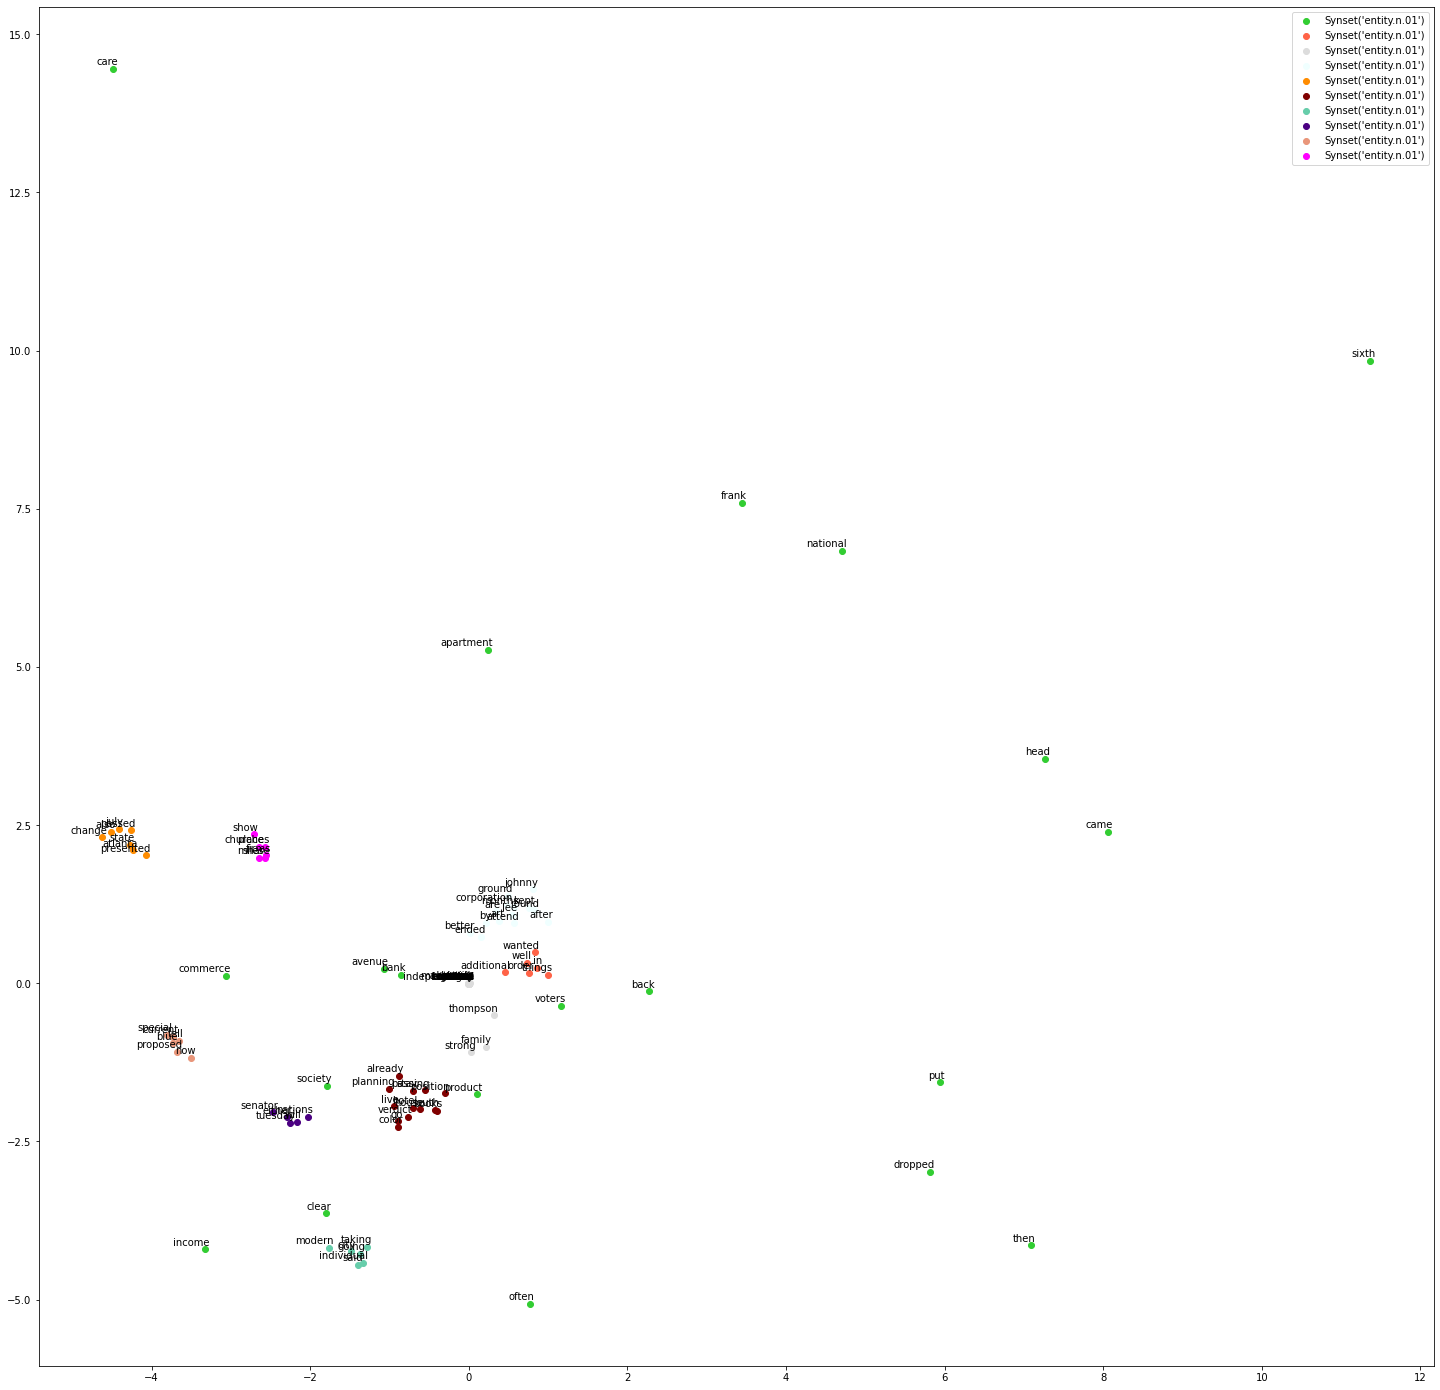

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [163]:
num_per_cluster = 20
num_labeled_per_cluster = 10

plt.figure(figsize = (25, 25))

colors = np.random.choice(np.array(list(mcolors.CSS4_COLORS.items()))[:, 0], 10, replace = False)

# go through all clusters
for i, cluster in enumerate(clusters[:10]):
    # select color
    color = colors[i]
    # choose random words to display
    random_instances = np.random.choice(cluster, min(len(cluster), num_per_cluster), replace = False)
    
    wn_words = [word for word in index2word[random_instances] if len(wn.synsets(word)) != None]
    wn_words = iter(wn_words)
    common_hypernym = None
    for word in wn_words:
        if common_hypernym is None:
            try:
                common_hypernyms = wn.synsets(word)[0].lowest_common_hypernyms(wn.synsets(next(wn_words))[0])
            except:
                break
        else:
            common_hypernyms = wn.synsets(word)[0].lowest_common_hypernyms(common_hypernym)
            
        if len(common_hypernyms) != 0:
            common_hypernym = common_hypernyms[0]
    
    for i, (x,y) in enumerate(index2vector[random_instances]):
        if i == 0:
            plt.scatter(x, y, color = color, label = common_hypernym)
        else:
            plt.scatter(x, y, color = color)
        plt.annotate(index2word[random_instances[i]],
                    xy = (x,y),
                    xytext=(5,2),
                    textcoords="offset points",
                    ha="right",
                    va="bottom")
    
        
plt.legend()
plt.show()
plt.save("embeddings.png")